In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.applications import VGG16, EfficientNetB0, MobileNetV2, ResNet50, Xception
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.applications.resnet import preprocess_input as resnet50_preprocess_input
from keras.applications.inception_v3 import preprocess_input as inceptionv3_preprocess_input
from keras.applications.xception import preprocess_input as xception_preprocess_input
from keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess_input

from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import zipfile
import cv2
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GaussianNoise, Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
# Set the model name and pre-trained model here
model_name = 'MobileNet_mod'

#required pixel ratio
pixel_width, pixel_height = 96, 96

pretrained_model = MobileNetV2(include_top=False, input_shape=(pixel_width, pixel_width, 3))

preprocessing_function = mobilenet_v2_preprocess_input

9406464/9406464 [==============================] - 1s 0us/step


In [4]:
#directory
dir = '/content/drive/MyDrive/ML-6375/Project/'
data_dir = dir + 'data/'
model_dir = dir + 'model/'
plot_dir = dir + 'plots/'

In [5]:
#reading data
data = pd.read_csv(data_dir + 'fer2013.csv')

In [6]:
# #identify faces
# def detect_faces(image, cascade, scale_factor=1.1, min_neighbors=5):
#     faces = cascade.detectMultiScale(image, scaleFactor=scale_factor, minNeighbors=min_neighbors)
#     return faces

# def crop_faces(image, faces):
#     cropped_faces = []
#     for (x, y, w, h) in faces:
#         cropped_face = image[y:y + h, x:x + w]
#         cropped_faces.append(cropped_face)
#     return cropped_faces

# def preprocess_faces(faces, width, height, pixel_width, pixel_height, pixels):
#     face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
#     for pixel_sequence in pixels:
#         face = [int(pixel) for pixel in pixel_sequence.split(' ')]
#         face = np.asarray(face).reshape(width, height)
#         face = face.astype('uint8')
        
#         detected_faces = detect_faces(face, face_cascade)
#         if len(detected_faces) > 0:
#             cropped_faces = crop_faces(face, detected_faces)
#             resized_face = cv2.resize(cropped_faces[0], (pixel_width, pixel_height))
#         else:
#             resized_face = cv2.resize(face, (pixel_width, pixel_height))

#         faces.append(resized_face.astype('float32'))
#     return faces

# # Preprocessing
# pixels = data['pixels'].tolist()
# width, height = 48, 48
# pixel_width, pixel_height = 48, 48 
# faces = []
# faces = preprocess_faces(faces, width, height, pixel_width, pixel_height, pixels)

# faces = np.asarray(faces)
# faces = np.expand_dims(faces, -1)
# emotions = pd.get_dummies(data['emotion']).values

In [7]:
# # Preprocessing
# pixels = data['pixels'].tolist()
# width, height = 48, 48
# faces = []
# for pixel_sequence in pixels:
#     face = [int(pixel) for pixel in pixel_sequence.split(' ')]
#     face = np.asarray(face).reshape(width, height)
#     face = cv2.resize(face.astype('uint8'), (width, height))
#     faces.append(face.astype('float32'))
# faces = np.asarray(faces)
# faces = np.expand_dims(faces, -1)
# emotions = pd.get_dummies(data['emotion']).values

In [8]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [9]:
# # Splitting dataset
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.2, random_state=42)

# Splitting dataset based on 'Usage' column
train_data = data[data['Usage'] == 'Training']
validation_data = data[data['Usage'] == 'PrivateTest']
test_data = data[data['Usage'] == 'PublicTest']

# Preprocessing function for faces
def preprocess_faces(data):
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'), (pixel_width, pixel_height))
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    return faces

# Preprocess faces for train, validation, and test sets
X_train = preprocess_faces(train_data)
X_validation = preprocess_faces(validation_data)
X_test = preprocess_faces(test_data)

# Get emotion labels for train, validation, and test sets
y_train = pd.get_dummies(train_data['emotion']).values
y_validation = pd.get_dummies(validation_data['emotion']).values
y_test = pd.get_dummies(test_data['emotion']).values


In [10]:
# Data augmentation
data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    brightness_range=(0.8, 1.2),
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    horizontal_flip=True)

In [11]:
# Function to create a model
def create_model(pretrained_model, num_classes):
    
    # Modifying the model
    for layer in pretrained_model.layers[:-6]:
        layer.trainable = False

    x = pretrained_model.output
    x = Flatten()(x)
    #x = GaussianNoise(0.1)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(7, activation='softmax')(x)

    model = Model(pretrained_model.input, x)

    # Create the final model
    model = Model(pretrained_model.input, x)

    # # Freeze the layers of the pretrained model
    # for layer in pretrained_model.layers:
    #     layer.trainable = False

    # Print the model summary
    print(f"Model: {model_name}")
    model.summary()
    
    return model


In [12]:
#preprocess function
def preprocess_input(X, preprocessing_function, convert_to_3_channels=False):
    X = X.astype("float32")
    
    if convert_to_3_channels:
        X = np.repeat(X, 3, axis=-1)  # Convert grayscale to 3-channel images
        
    X = preprocessing_function(X)
    return X

In [13]:
#plotting
def plot_metrics(history, model_name, metric='loss'):
    plt.figure()
    plt.plot(history.history[metric], label=f'train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'validation {metric}')
    plt.title(f'{model_name} - {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.savefig(plot_dir +f'{model_name}_{metric}.png')
    plt.show()

In [14]:
def print_tpr_fpr(cm, emotion_labels):
    tpr = np.diag(cm) / np.sum(cm, axis=1)
    fpr = (np.sum(cm, axis=0) - np.diag(cm)) / (np.sum(cm) - np.sum(cm, axis=0))

    print("True Positive Rates:")
    for label, rate in zip(emotion_labels, tpr):
        print(f"{label}: {rate:.2f}")

    print("\nFalse Positive Rates:")
    for label, rate in zip(emotion_labels, fpr):
        print(f"{label}: {rate:.2f}")

In [15]:
def plot_model_confusion_matrix(model, X_test, y_test, emotion_labels, model_name):
    # Get the model's predictions
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using ConfusionMatrixDisplay
    fig, ax = plt.subplots(figsize=(8, 8))
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
    display.plot(cmap=plt.cm.Blues, ax=ax)

    # Set the title, xlabel, and ylabel
    ax.set_title(f'Confusion Matrix for {model_name}', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)

    # Save the figure to a file
    plt.savefig(plot_dir + f'{model_name}_confusion_matrix.png')

    # Show the figure
    plt.show()



In [16]:
# Function to train and evaluate a model
def train_evaluate_model(X_train, y_train, X_validation, y_validation, X_test, y_test, emotion_labels, model_name, num_classes=7):
    # Preprocess the dataset
    X_train_processed = preprocess_input(X_train, preprocessing_function, convert_to_3_channels=True)

    # Split the training data into train and validation sets
    X_val_processed = preprocess_input(X_validation, preprocessing_function, convert_to_3_channels=True)
    
    #for evalution purpose - finding accuracy after training
    X_test_processed = preprocess_input(X_test, preprocessing_function, convert_to_3_channels=True)

    # Create the model
    model = create_model(pretrained_model, num_classes)

    # Save the model
    model_path = model_dir + f'{model_name}.h5'

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    # Set up callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    # Train the model
    history = model.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_validation), epochs=100, batch_size=64, callbacks=[early_stopping, reduce_lr, checkpoint])

    # # Save the models
    # model_path = model_dir + f'{model_name}.h5'
    # model.save(model_path)

    # Generate and save plots for loss and accuracy
    plot_metrics(history, model_name, metric='loss')
    plot_metrics(history, model_name, metric='accuracy')

    # Evaluate the model
    score = model.evaluate(X_test_processed, y_test, verbose=0)
    accuracy = score[1]

    return accuracy

In [17]:
# Function to run experiments with a single pre-trained model
def run_experiment(model_name, pretrained_model, X_train, y_train, X_validation, y_validation, X_test, y_test,  emotion_labels):
    results = {}
    
    # Train and evaluate the model
    accuracy = train_evaluate_model(X_train, y_train, X_validation, y_validation, X_test, y_test, emotion_labels, model_name)

    # Load the saved model
    model_path = model_dir + f'{model_name}.h5'
    model = load_model(model_path)

    # Predict the probabilities of each class
    X_test_processed = preprocess_input(X_test, preprocessing_function, convert_to_3_channels=True)
    y_pred_probs = model.predict(X_test_processed)

    # Calculate the confusion matrix
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    # Calculate the classification report
    cr = classification_report(y_true, y_pred, target_names=emotion_labels, output_dict=True)

    # Calculate the ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')

    # Extract F1 score, precision, and recall from the classification report
    f1_scores = {label: cr[label]['f1-score'] for label in emotion_labels}
    precision_scores = {label: cr[label]['precision'] for label in emotion_labels}
    recall_scores = {label: cr[label]['recall'] for label in emotion_labels}

    #plotting confusion metrics
    plot_model_confusion_matrix(model, X_test_processed, y_test, emotion_labels, model_name)

    # Store the results
    results['accuracy'] = accuracy
    results['confusion_matrix'] = cm
    results['classification_report'] = cr
    results['roc_auc'] = roc_auc
    results['f1_scores'] = f1_scores
    results['precision_scores'] = precision_scores
    results['recall_scores'] = recall_scores

    return results

Model: MobileNet_mod
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                       

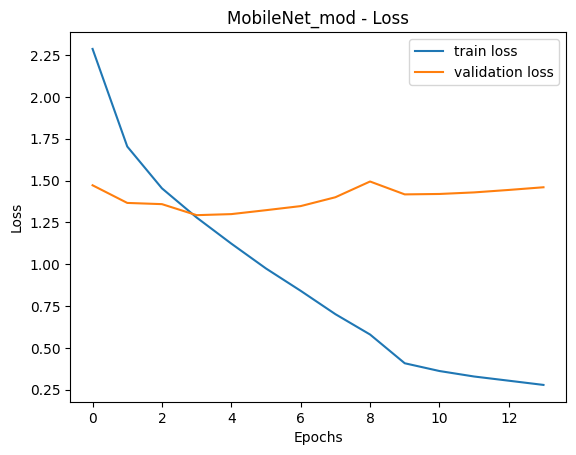

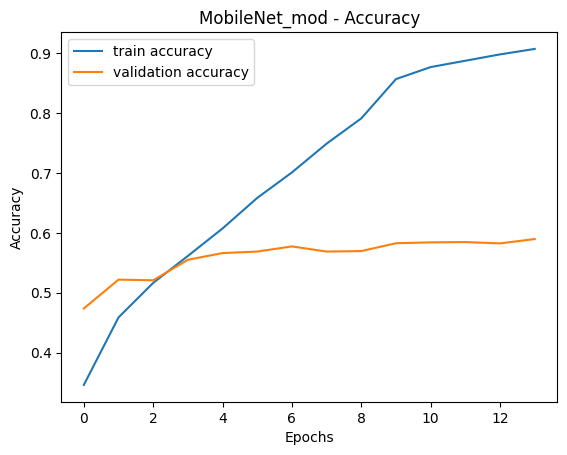

113/113 [==============================] - 1s 9ms/step


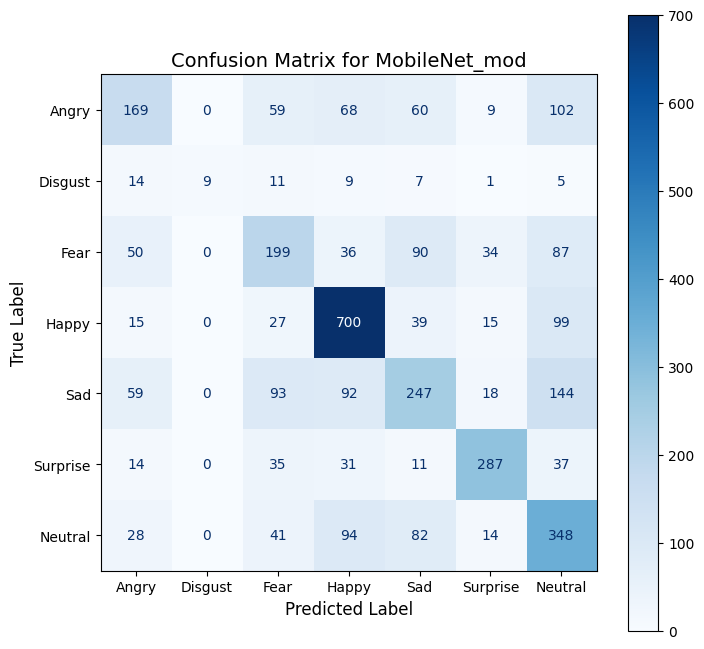

In [18]:
# Run the experiment
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
results = run_experiment(model_name, pretrained_model, X_train, y_train, X_validation, y_validation, X_test, y_test, emotion_labels)

In [19]:
# Print the results
print(f"Results for {model_name}:")
print(f"Accuracy: {results['accuracy']}")
print("F1 scores:", results['f1_scores'])
print("Precision scores:", results['precision_scores'])
print("Recall scores:", results['recall_scores'])

# Print the TPR and FPR for each class
print(f"The TPR and FPR for each class:")
print_tpr_fpr(results['confusion_matrix'], emotion_labels)

print(f"Confusion Matrix:")
print(results['confusion_matrix'])
print(f"Classification Report:")
print(results['classification_report'])
print(f"ROC AUC: {results['roc_auc']}")
print("\n")

Results for MobileNet_mod:
Accuracy: 0.545834481716156
F1 scores: {'Angry': 0.41421568627450983, 'Disgust': 0.27692307692307694, 'Fear': 0.41415192507804377, 'Happy': 0.7272727272727273, 'Sad': 0.415475189234651, 'Surprise': 0.7238335435056747, 'Neutral': 0.48705388383484954}
Precision scores: {'Angry': 0.48424068767908307, 'Disgust': 1.0, 'Fear': 0.42795698924731185, 'Happy': 0.6796116504854369, 'Sad': 0.4608208955223881, 'Surprise': 0.7592592592592593, 'Neutral': 0.4233576642335766}
Recall scores: {'Angry': 0.3618843683083512, 'Disgust': 0.16071428571428573, 'Fear': 0.4012096774193548, 'Happy': 0.7821229050279329, 'Sad': 0.3782542113323124, 'Surprise': 0.691566265060241, 'Neutral': 0.5733113673805601}
The TPR and FPR for each class:
True Positive Rates:
Angry: 0.36
Disgust: 0.16
Fear: 0.40
Happy: 0.78
Sad: 0.38
Surprise: 0.69
Neutral: 0.57

False Positive Rates:
Angry: 0.06
Disgust: 0.00
Fear: 0.09
Happy: 0.13
Sad: 0.09
Surprise: 0.03
Neutral: 0.17
Confusion Matrix:
[[169   0  59  68

Average confusion matrix:
[[ 279  232]
 [ 232 2843]]


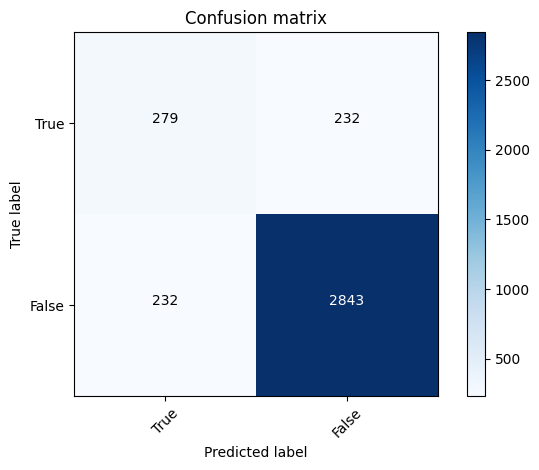

In [20]:
import itertools
# Assume you have a single confusion matrix
confusion_matrix = results['confusion_matrix']

# Calculate the average confusion matrix using one-versus-many approach
num_labels = confusion_matrix.shape[0]
avg_confusion_matrix = np.zeros((2, 2))

for label in range(num_labels):
    tp = confusion_matrix[label, label]
    fn = np.sum(confusion_matrix[label, :]) - tp
    fp = np.sum(confusion_matrix[:, label]) - tp
    tn = np.sum(confusion_matrix) - tp - fn - fp

    one_vs_many_cm = np.array([
        [tp, fp],
        [fn, tn]
    ])

    avg_confusion_matrix += one_vs_many_cm

avg_confusion_matrix = avg_confusion_matrix // num_labels
avg_confusion_matrix = avg_confusion_matrix.astype(int)

print(f'Average confusion matrix:\n{avg_confusion_matrix}')

# Function to plot the confusion matrix
def plot_avg_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # Save the figure to a file
    plt.savefig(plot_dir + f'{model_name}_avg_confusion_matrix.png')
    plt.show()

# Plot the average confusion matrix
class_names = ['True', 'False']
plot_avg_confusion_matrix(avg_confusion_matrix, class_names)
